In [27]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import os
import shutil
import scipy as sp
import sys
from matplotlib import gridspec
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LogNorm

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics

FontSize=25
FontSizeLabelAxis=25
rc('legend',fontsize=FontSize)
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
font = {'family' : 'normal',
        'size'   : FontSize}

rc('font', **font)
rc('text', usetex=True)

# scaling factors
mm=1e3
MV=1e-6
kV=1e-3
mu0 = sp.constants.mu_0

cms = sp.constants.speed_of_light

time = 3.36678*10**-11
zloc = time*cms
print(zloc)

0.010093352517452399


In [28]:
direc = 'gaussian/notphilippe/notpoynt/19022_many_vdiff/'
direc = 'gaussian/notphilippe/notpoynt/19280_final/'
direc = 'gaussian/notphilippe/notpoynt/19376_angle40/'
direc = 'gaussian/notphilippe/notpoynt/19559_angle42p5/'
direc = 'gaussian/notphilippe/notpoynt/19374_angle45/'
direc = 'gaussian/notphilippe/notpoynt/19951_angle45_moredom/'
direc = 'gaussian/notphilippe/notpoynt/19956_angle45_Moredom/'
#direc = 'gaussian/notphilippe/notpoynt/19560_angle47p5/'
#direc = 'gaussian/notphilippe/notpoynt/19377_angle50/'
# has to be 1 less than reported number of diags, because of 0


direc = '1nC/1beam/3warpx/erika/25803_erika_quicklambda/'


Nitera = 3 # 78 650 500

txtfile = '/lstr/sahara/aard/cphillips/'+direc+'diags/reducedfiles/reduced_diags.txt'

filedir = '/lstr/sahara/aard/cphillips/'+direc+'diags/slabmovingwarpx/'



In [29]:
ts = LpaDiagnostics(filedir)
N_iterations = len(ts.iterations)
print(N_iterations)

11


In [30]:
#ts = LpaDiagnostics(filedir)

#N_iterations = len(ts.iterations)
#print(N_iterations)
if Nitera==-1:
   it = ts.iterations[N_iterations-1]
else:
   it = ts.iterations[Nitera]

# -------------------------------------------------------------------------
# retrieve the data from the hdf5 file for the electric and magnetic fields
# -------------------------------------------------------------------------
Ez, info_Ez = ts.get_field( iteration=it,  field='E', coord='z',
                            slicing_dir='x', plot=False)
Ex, info_Ex = ts.get_field( iteration=it,  field='E', coord='x',
                            slicing_dir='x', plot=False)
Ey, info_Ey = ts.get_field( iteration=it,  field='E', coord='y',
                            slicing_dir='x', plot=False)
Bx, info_Bx = ts.get_field( iteration=it,  field='B', coord='x',
                            slicing_dir='x', plot=False)
By, info_By = ts.get_field( iteration=it,  field='B', coord='y',
                            slicing_dir='x', plot=False)
Bz, info_Bz = ts.get_field( iteration=it,  field='B', coord='z',
                            slicing_dir='x',plot=False)
xf, yf, zf, px, py, pz = ts.get_particle( ['x','y','z','ux','uy','uz'],  species='myparticle', iteration=it)



shapeEz= np.shape(Ez)
print('z, y, x grid size: ',shapeEz)
absmax=MV*max(np.max(np.max(np.abs(Ez))),np.abs(np.min(np.min(np.abs(Ez)))))

xsc=np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm, shapeEz[2])
ysc=np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm, shapeEz[1])
zsc=np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm, shapeEz[0])


print('Domain:')
print('xmin/max: ',info_Ez.xmin*mm, info_Ez.xmax*mm)
print('ymin/max: ',info_Ez.ymin*mm, info_Ez.ymax*mm)
print('zmin/max: ',info_Ez.zmin*mm, info_Ez.zmax*mm)

print('zmean: ',np.round(np.mean(zf),6)*mm,' mm')
print('last particle z: ',np.round(np.min(zf),6)*mm,' mm')
print('x=y=0 structure exit in z: ',100-(1+.4+.16), ' mm')

print('first particle z: ',np.round(np.max(zf),6)*mm,' mm')


# Let's convert to poynting vector
Sx = (1/mu0)*(Ey*Bz-Ez*By)
Sy = (1/mu0)*(Ez*Bx-Ex*Bz)
Sz = (1/mu0)*(Ex*By-Ey*Bx)


z, y, x grid size:  (2048, 256, 64)
Domain:
xmin/max:  -2.9752734375 2.9752734375
ymin/max:  -17.56353515625 2.5635351562500013
zmin/max:  -28.59800501031735 154.9551653223418
zmean:  142.36599999999999  mm
last particle z:  140.37199999999999  mm
x=y=0 structure exit in z:  98.44  mm
first particle z:  144.406  mm


2.8000005


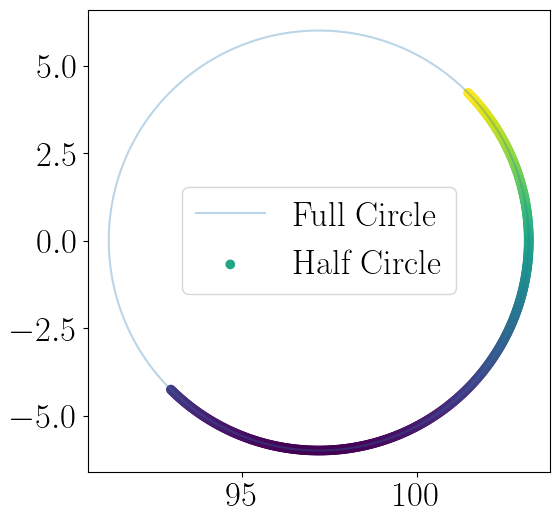

In [122]:
# get indices of half circ around (0,0,100-angle)
# what radius do we want in mm?
radius = 6
angle = 45
full_height = 2 + 2*0.4 + 500e-9 # vac_y + wall + cond_y
print(full_height)

y_start = 0
z_start = 100 - full_height/np.tan(np.radians(angle))

# get the full circle
theta = np.linspace(0, 2 * np.pi, 1000)  # Generate 1000 points along the circle
z = radius * np.cos(theta)
y = radius * np.sin(theta)

points = np.column_stack((z, y))

start_angle = np.radians(angle)  # Convert to radians
end_angle = start_angle+np.pi  # 180 degrees added to start_angle
# Mask for points within the desired angular range
angles = np.arctan2(y, z)  # Get angles of each point
angles = (angles + 2 * np.pi) % (2 * np.pi)  # Normalize to [0, 2π]
mask = (angles >= start_angle) & (angles <= end_angle)

# Filter points
half_circle_points = points[~mask]

# Split x and y coordinates of filtered points
half_circle_z, half_circle_y = half_circle_points[:, 0], half_circle_points[:, 1]

zplot = z + z_start
yplot = y + y_start
half_z = half_circle_z + z_start
half_y = half_circle_y + y_start

# Plot to visualize
plt.figure(figsize=(6, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(half_y.min(),half_y.max())
line_colors=cmap(norm(half_y))
plt.plot(zplot, yplot, label="Full Circle", alpha=0.3)
plt.scatter(half_z, half_y, color=line_colors, label="Half Circle")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

### Now, get the indices for the closest (z,y)

In [123]:
# get the arrays of y and z for indexing
zs = np.linspace(info_Ez.zmin*mm, info_Ez.zmax*mm,shapeEz[0])
ys = np.linspace(info_Ez.ymin*mm, info_Ez.ymax*mm,shapeEz[1])
xs = np.linspace(info_Ez.xmin*mm, info_Ez.xmax*mm,shapeEz[2])

# get closest indices for half circle
y_index = []
z_index = []
for i in np.arange(len(half_y)):
    oney = half_y[i]
    y_index.append((np.abs(ys-oney)).argmin())
    onez = half_z[i]
    z_index.append((np.abs(zs-onez)).argmin())
    onex = 0
    x_index = (np.abs(xs-onex)).argmin()

Sxs = np.array([Sx[z_index[i],y_index[i],x_index] for i in np.arange(len(y_index))])
Sys = np.array([Sy[z_index[i],y_index[i],x_index] for i in np.arange(len(y_index))])
Szs = np.array([Sz[z_index[i],y_index[i],x_index] for i in np.arange(len(y_index))])

In [124]:
# prep the S for plotting
anglesy = np.arctan(Sys/Szs)
anglesydeg = anglesy*180/np.pi

anglesx = np.arctan(Sxs/Szs)
anglesxdeg = anglesx*180/np.pi

magsy = [np.sqrt(Sys[i]**2 + Szs[i]**2) for i in np.arange(len(Sys))]
magsx = [np.sqrt(Sxs[j]**2 + Szs[j]**2) for j in np.arange(len(Sxs))]

#print(anglesydeg,magsy)

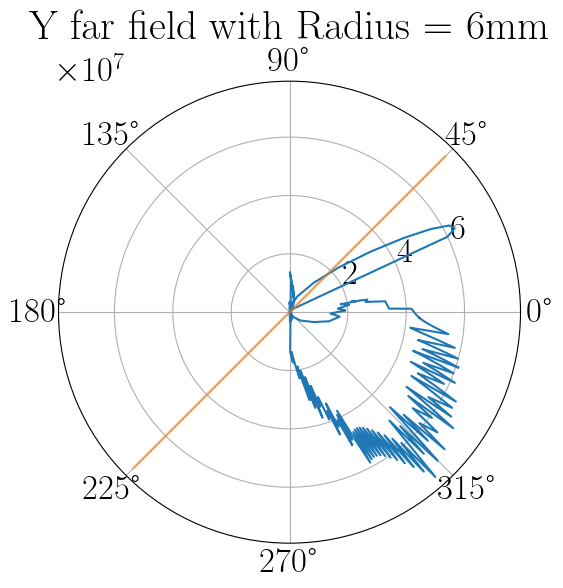

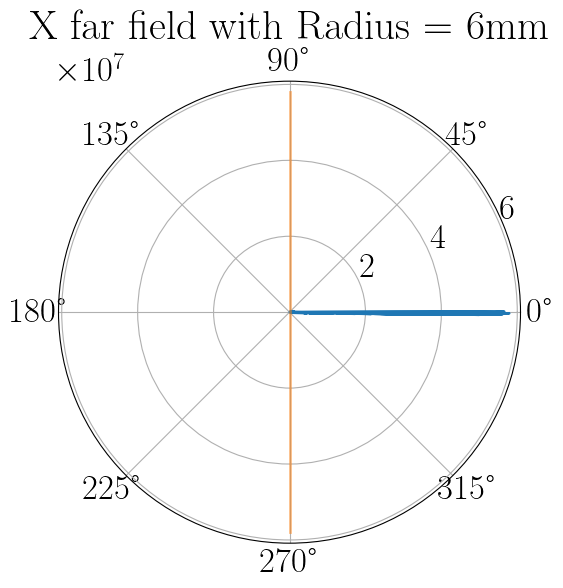

In [125]:
fig,ax = plt.subplots(subplot_kw={'projection':'polar'},figsize=(6,6))
ax.plot(anglesy,magsy,label='far-field pattern')
ax.plot(np.array([angle+180,angle])*np.pi/180,[np.max(magsy),np.max(magsy)],linewidth=2,alpha=0.5,linestyle='-',label='surface')
ax.grid(True)
plt.title(f'Y far field with Radius = {radius}mm')
plt.show()

fig,ax = plt.subplots(subplot_kw={'projection':'polar'},figsize=(6,6))
ax.plot(anglesx,magsx,label='far-field pattern in x')
ax.plot(np.array([270,90])*np.pi/180,[np.max(magsx),np.max(magsx)],linewidth=2,alpha=0.5,linestyle='-',label='surface')
ax.grid(True)
plt.title(f'X far field with Radius = {radius}mm')
plt.show()

### Let's plot

In [126]:
# Get the range we want in x, y, and z
xlow = -1.55
xhigh = 1.55
xlow = info_Ez.xmin*mm # 60 50
xhigh = info_Ez.xmax*mm # 80
lenx = xhigh-xlow
xticklist = np.arange(xlow,xhigh+lenx/2,lenx/4)
xticklist = [round(i,1) for i in xticklist]
xindexmin = (np.abs(xsc - xlow)).argmin()
xindexmax = (np.abs(xsc - xhigh)).argmin()
print('x desired: ', xlow, xhigh, ' mm')
print('x acheived: ', xsc[xindexmin],xsc[xindexmax], ' mm')
print('xindexmin: ',xindexmin,' xindexmax: ',xindexmax)

# where is the slice for x=0?
xindex0 = (np.abs(xsc - 0)).argmin()
print('x = 0 acheived: ',xsc[xindex0], ' mm')
xindex0 = xindex0-xindexmin

ylow = -10
yhigh = 1.55
#ylow = info_Ez.ymin*mm # 60 50
#yhigh = info_Ez.ymax*mm # 80
leny = yhigh-ylow
yticklist = np.arange(ylow,yhigh+leny/2,leny/4)
yticklist = [round(i,1) for i in yticklist]
yindexmin = (np.abs(ysc - ylow)).argmin()
yindexmax = (np.abs(ysc - yhigh)).argmin()
print('y desired: ', ylow, yhigh, ' mm')
print('y acheived: ', ysc[yindexmin],ysc[yindexmax], ' mm')
print('y indexmin: ',yindexmin,' y indexmax: ',yindexmax)

# where is the slice for y=0?
yindex0 = (np.abs(ysc - 0)).argmin()
print('y = 0 acheived: ',ysc[yindex0], ' mm')
print('y = 0 index: ',yindex0)

zlow = 90
zhigh = 110
#zlow = info_Ez.zmin*mm
#zhigh = info_Ez.zmax*mm
lenz = zhigh-zlow-2
zticklist = np.arange(zlow+1,zhigh-1+lenz/2,lenz/4)
zticklist = [round(i,1) for i in zticklist]
print(zticklist)
zindexmin = (np.abs(zsc - zlow)).argmin()
zindexmax = (np.abs(zsc - zhigh)).argmin()
if zindexmin == 0:
    zindexmax = zindexmax-1
print('z desired: ', zlow, zhigh, ' mm')
print('z acheived: ', zsc[zindexmin],zsc[zindexmax], ' mm')
print('z indexmin: ',zindexmin,' z indexmax: ',zindexmax)

# higher number, larger gradient
mult = 1 

# pvplot = 0, no; 1, ; 2, 
pvplot = 2
pv2scale = 5000000000 # larger number = smaller arrows
#avg_PVn = [ 0.06160164, -0.51742454,  0.38209828] 
#avg_PV = [   357.15761471, -30179.31971494,  13167.58016861]

x desired:  -2.9752734375 2.9752734375  mm
x acheived:  -2.9752734375 2.9752734375  mm
xindexmin:  0  xindexmax:  63
x = 0 acheived:  -0.04722656249999968  mm
y desired:  -10 1.55  mm
y acheived:  -9.98628515625 1.5374492187500017  mm
y indexmin:  96  y indexmax:  242
y = 0 acheived:  0.03778515625000267  mm
y = 0 index:  223
[91.0, 95.5, 100.0, 104.5, 109.0, 113.5]
z desired:  90 110  mm
z acheived:  90.03455207327231 110.03081830882824  mm
z indexmin:  1323  z indexmax:  1546


index of y=0:  223
yloc we are able to get:  0.03778515625000267  mm
(63, 223)


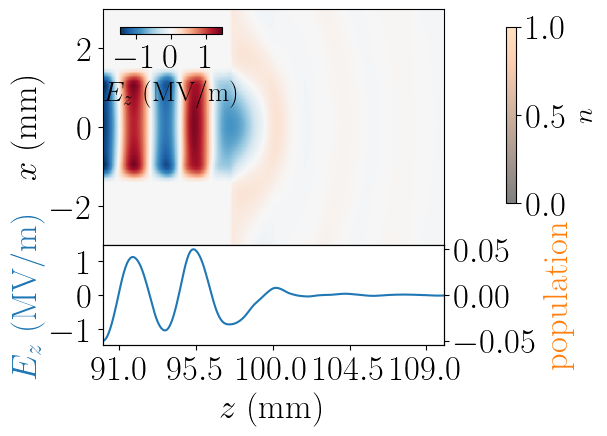

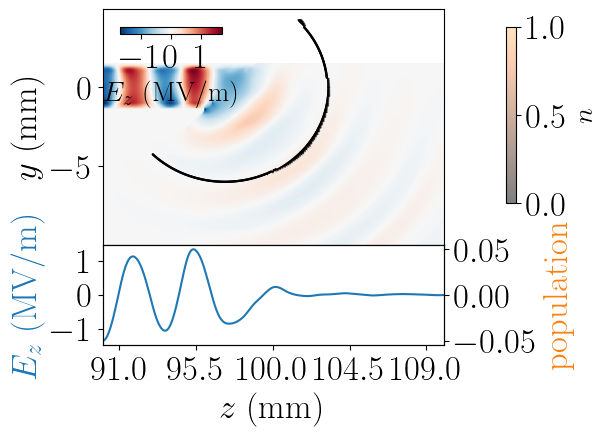

In [127]:
# PLOT POYNTING VECTOR?


# Center in y for offset structure; always want on axis
yloc = 0
index_y0 = (np.abs(ysc - yloc)).argmin()
print('index of y=0: ',index_y0)
print('yloc we are able to get: ',ysc[index_y0], ' mm')

# generate a plot of the Ez wake in (z,y) with lineout of Ez
fig=plt.figure(9999)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])


# record Ez in the (z,x) plane for y=0
yEzslice=Ez[zindexmin:zindexmax,yindex0,xindexmin:xindexmax].transpose()*MV # gets the x=0 slice
yEzslice = np.flipud(yEzslice)
shapeyEzslice = np.shape(yEzslice)

yEabsmax = max(np.max(np.max(np.abs(yEzslice))),np.abs(np.min(np.min(np.abs(yEzslice)))))

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(yEzslice,extent=[zsc[zindexmin],zsc[zindexmax], xsc[xindexmin],xsc[xindexmax]],
                   cmap='RdBu_r', vmin=-yEabsmax/mult, vmax=yEabsmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$x$ (mm)', fontsize=FontSizeLabelAxis)

# record particle and plot a histogram on top of 3d of Ez - NEED TO ADJUST AXES FOR THIS
particles=ax1.hexbin(zf*mm, xf*mm, gridsize=200,extent=[zsc[zindexmin],zsc[zindexmax], xsc[xindexmin],xsc[xindexmax]], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(loczs,locx,PV[2],PV[0],color='g',scale=3)
#elif pvplot ==2:
#    for i in np.arange(len(pvx)):
#        pv = ax1.quiver(xs[i],zs[i],Sxs[i],Szs[i],color='k',scale=pv2scale)
#        print('Angle wrt x axis from bottom to top')
#        print(anglexdeg)

    


# Line plot of Ez plus histogram of the population on lower plot
zsca=np.linspace(zsc[zindexmin],zsc[zindexmax], zindexmax-zindexmin)
print(np.shape(yEzslice))
ax2.plot (zsca,yEzslice[xindex0,:]) # gets the y=0 slice
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(zticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zsc[zindexmin],zsc[zindexmax]),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9999)
#plt.savefig(save_dir+fig9999p,dpi=600)
#plt.savefig(plotnms[pn]+'x.png')
plt.show()



#-------------------------------------------------------------------------
# record Ez in the (z,y) plane for x=0
fig=plt.figure(9998)
gs1 = gridspec.GridSpec(11, 13)
ax1 = fig.add_subplot(gs1[0:7,1:10])
ax2 = fig.add_subplot(gs1[7:10,1:10], sharex =ax1)
ax3 = fig.add_subplot(gs1[0:7,11:12])

# record Ez in the (z,y) plane for x=0
xEzslice=Ez[zindexmin:zindexmax,yindexmin:yindexmax,xindex0].transpose()*MV # gets the x=0 sliceplt.gca().invert_yaxis()
xEzslice = np.flipud(xEzslice)
shapexEzslice = np.shape(xEzslice)
xEabsmax = max(np.max(np.max(np.abs(xEzslice))),np.abs(np.min(np.min(np.abs(xEzslice)))))

# plot slice (upper plot with red and blue lines)
imField=ax1.imshow(xEzslice,extent=[zsc[zindexmin],zsc[zindexmax], ysc[yindexmin],ysc[yindexmax]],
                   cmap='RdBu_r', vmin=-xEabsmax/mult, vmax=xEabsmax/mult, aspect='auto')
cbaxes = inset_axes(ax1, width="30%", height="3%", loc=2)
cbar1  = fig.colorbar(imField, cax=cbaxes, orientation='horizontal').set_label(label=r'$E_z$ (MV/m)',size=20)
ax1.set_ylabel(r'$y$ (mm)', fontsize=FontSizeLabelAxis)
plt.gca().invert_yaxis()

# record particle and plot a histogram on top of 3d of Ez
particles=ax1.hexbin(zf*mm, yf*mm, gridsize=200,extent=[zsc[zindexmin],zsc[zindexmax], ysc[yindexmin],ysc[yindexmax]], cmap='copper', alpha=0.5,  mincnt=5)
ax3.axis('off')
cbaxes2 = inset_axes(ax3, width="30%", height="75%", loc=2)
cbar2 = fig.colorbar(particles, cax=cbaxes2).set_label(label=r'$n$ ',size=20)

if pvplot == 1:
    pv = ax1.quiver(loczs,locy,PV[2],PV[1],color='g',scale=3)
elif pvplot ==2:
    for i in np.arange(len(Sys)):
        pv = ax1.quiver(half_z[i],half_y[i],Szs[i],Sys[i],color='k',scale=pv2scale)
#    print('Angle wrt y axis from bottom to top')
#    print(angleydeg)


#zplotS,xplotS,avgPVz[1,:],avgPVx[1,:]

# Line plot of Ez plus histogram of the population on lower plot
zscb=np.linspace(zsc[zindexmin],zsc[zindexmax], zindexmax-zindexmin)
nyindex0 = yindex0-yindexmin
ax2.plot (zscb,xEzslice[shapexEzslice[0]-nyindex0,:]) #int(shapeEzslice[0]/2),:]) # Ez slice has shape (ylen,zlen)
#ax2.plot (zscb,Ey[16,48,:]*1e-6)
#ax2.plot (zscb,Ex[16,48,:]*1e-6)
ax2.set_xlabel(r'$z$ (mm)', fontsize=FontSizeLabelAxis)
ax2.set_ylabel(r'$E_z$ (MV/m) ', fontsize=FontSizeLabelAxis, color="C0")
ax2.set_xticks(zticklist)
ax22 = ax2.twinx()
ax22.hist(zf*mm,shapeEz[0], range=(zsc[zindexmin],zsc[zindexmax]),alpha=0.3, color='C1')
ax22.set_ylabel(r'population', fontsize=FontSizeLabelAxis, color="C1")

# Set up the plots
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.subplots_adjust(hspace=.0)

# Save the plot to be viewed
#plt.savefig(save_dir+fig9998)
#plt.savefig(save_dir+fig9998p,dpi=600)
#plt.savefig(plotnms[pn]+'y.png')
plt.show()



In [128]:
print(half_z,half_y)

[103.1999995  103.19988083 103.19952482 103.19893148 103.19810084
 103.19703293 103.1957278  103.19418549 103.19240606 103.1903896
 103.18813616 103.18564586 103.18291877 103.17995502 103.17675472
 103.17331799 103.16964497 103.16573581 103.16159067 103.15720969
 103.15259307 103.14774097 103.1426536  103.13733116 103.13177384
 103.12598189 103.11995551 103.11369496 103.10720048 103.10047233
 103.09351076 103.08631607 103.07888853 103.07122844 103.06333609
 103.05521181 103.04685591 103.03826872 103.02945059 103.02040186
 103.01112289 103.00161405 102.99187571 102.98190826 102.97171209
 102.96128761 102.95063523 102.93975537 102.92864846 102.91731493
 102.90575525 102.89396986 102.88195923 102.86972384 102.85726417
 102.84458072 102.83167398 102.81854446 102.80519269 102.79161919
 102.77782451 102.76380918 102.74957376 102.73511881 102.72044491
 102.70555263 102.69044257 102.67511532 102.65957149 102.6438117
 102.62783656 102.61164671 102.59524279 102.57862545 102.56179534
 102.5447531